In [ ]:
!apt-get install -y xvfb  # Установка виртуального дисплея
!pip install pyvirtualdisplay gymnasium pygame

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import numpy as np
import torch
import gym
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.utils import tensorboard

In [ ]:
np.bool8 = np.bool_

In [ ]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

In [ ]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [ ]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )

    def forward(self, X):
        return self.model(X)

In [ ]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, 1)
        )

    def forward(self, X):
        return self.model(X)

In [ ]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions, activation=Mish)
critic = Critic(state_dim, activation=Mish)
adam_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)

torch.manual_seed(1)

In [ ]:
def clip_grad_norm_(module, max_grad_norm):
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

def policy_loss(old_log_prob, log_prob, advantage, eps):
    ratio = (log_prob - old_log_prob).exp()
    clipped = torch.clamp(ratio, 1-eps, 1+eps)*advantage

    m = torch.min(ratio*advantage, clipped)
    return -m

In [ ]:
episode_rewards = []
gamma = 0.98
eps = 0.2
w = tensorboard.SummaryWriter()
s = 0
max_grad_norm = 0.5

for i in range(800):
    prev_prob_act = None
    done = False
    total_reward = 0
    state = env.reset()


    while not done:
        s += 1
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        prob_act = dist.log_prob(action)

        next_state, reward, done, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))

        w.add_scalar("loss/advantage", advantage, global_step=s)
        w.add_scalar("actions/action_0_prob", dist.probs[0], global_step=s)
        w.add_scalar("actions/action_1_prob", dist.probs[1], global_step=s)

        total_reward += reward
        state = next_state

        if prev_prob_act:
            actor_loss = policy_loss(prev_prob_act.detach(), prob_act, advantage.detach(), eps)
            w.add_scalar("loss/actor_loss", actor_loss, global_step=s)
            adam_actor.zero_grad()
            actor_loss.backward()
            # clip_grad_norm_(adam_actor, max_grad_norm)
            w.add_histogram("gradients/actor",
                             torch.cat([p.grad.view(-1) for p in actor.parameters()]), global_step=s)
            adam_actor.step()

            critic_loss = advantage.pow(2).mean()
            w.add_scalar("loss/critic_loss", critic_loss, global_step=s)
            adam_critic.zero_grad()
            critic_loss.backward()
            # clip_grad_norm_(adam_critic, max_grad_norm)
            w.add_histogram("gradients/critic",
                             torch.cat([p.data.view(-1) for p in critic.parameters()]), global_step=s)
            adam_critic.step()

        prev_prob_act = prob_act

    w.add_scalar("reward/episode_reward", total_reward, global_step=i)
    episode_rewards.append(total_reward)
    if i % 10 == 0:
      print(f"Episode: {i}, Score: {total_reward:.2f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0, Score: 29.00
Episode: 10, Score: 63.00
Episode: 20, Score: 33.00
Episode: 30, Score: 63.00
Episode: 40, Score: 64.00
Episode: 50, Score: 50.00
Episode: 60, Score: 161.00
Episode: 70, Score: 192.00
Episode: 80, Score: 149.00
Episode: 90, Score: 305.00
Episode: 100, Score: 443.00
Episode: 110, Score: 86.00
Episode: 120, Score: 243.00
Episode: 130, Score: 160.00
Episode: 140, Score: 152.00
Episode: 150, Score: 155.00
Episode: 160, Score: 162.00
Episode: 170, Score: 342.00
Episode: 180, Score: 198.00
Episode: 190, Score: 194.00
Episode: 200, Score: 247.00
Episode: 210, Score: 445.00
Episode: 220, Score: 500.00
Episode: 230, Score: 500.00
Episode: 240, Score: 500.00
Episode: 250, Score: 500.00
Episode: 260, Score: 500.00
Episode: 270, Score: 500.00
Episode: 280, Score: 500.00
Episode: 290, Score: 500.00
Episode: 300, Score: 500.00
Episode: 310, Score: 500.00
Episode: 320, Score: 500.00
Episode: 330, Score: 500.00
Episode: 340, Score: 500.00
Episode: 350, Score: 477.00
Episode: 3

In [ ]:
def plot_rewards_comparison(rewards1, rewards2=None, label1="ppo1", label2="ppo2", window=10):
    avg1 = np.convolve(rewards1, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(rewards1, alpha=0.3, label=f"{label1}")
    plt.plot(avg1, label=f"Среднее ({label1})", color="red")

    avg = []
    sum = 0
    for i in range(len(rewards1)):
        sum += rewards1[i]
        avg.append(sum / (i + 1))
    # print(avg)
    plt.plot(avg, alpha=0.3, label=f'AVG ({label1})', color='green')

    if rewards2 is not None:
        avg2 = np.convolve(rewards2, np.ones(window)/window, mode='valid')
        plt.plot(rewards2, alpha=0.3, label=f"{label2}")
        plt.plot(avg2, label=f"Среднее ({label2})", color="green")

    plt.xlabel("Эпизод")
    plt.ylabel("Суммарная награда")
    plt.title("ppo1 vs ppo2" if rewards2 is not None else "ppo1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

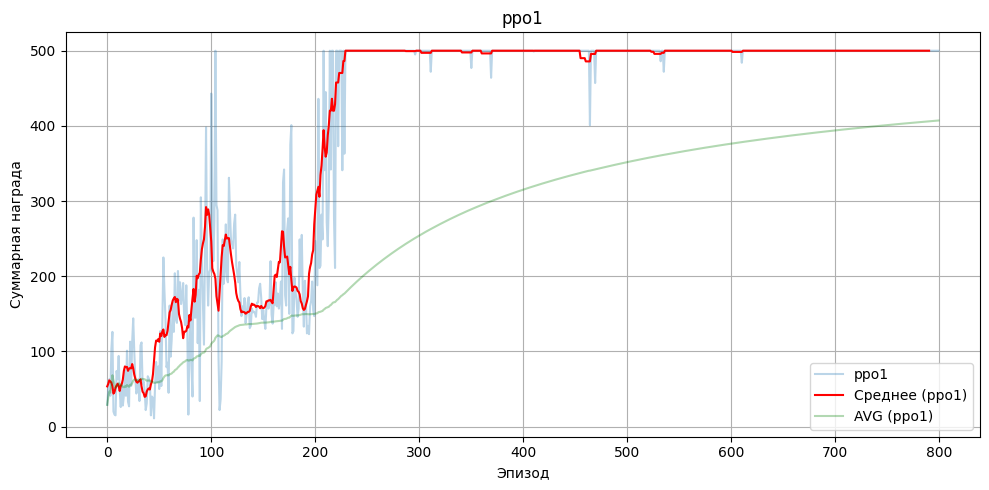

In [ ]:
plot_rewards_comparison(episode_rewards)